## <center> AGE OF EMPIRES II: DE PATCH 46295</center>

![46295](https://static.ageofempires.com/aoe/wp-content/uploads/2021/03/2021.03.24-PHOENIX_Update-46295.jpg)

### ANÁLISIS EXPLORATORIO DE LOS DATOS.

#### LIBRERÍAS UTILIZADAS.

In [1]:
## Importación de datos.
from sqlalchemy import create_engine

## Tratamiento de datos.
import pandas as pd
import numpy as np

## Gráficos.
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 14, 10

## Configuración warnings.
import warnings
warnings.filterwarnings('ignore')

#### QUERY A LA BBDD DE MARIADB.

In [2]:
# Nombre de usuario, contraseña y BBDD MySQL.
mysql_address = 'xxx.xxx.xxx.xxx'
mysql_port = 'xxx'
mysql_username = 'xxx'
mysql_password = 'xxx'
mysql_dbname = 'xxx'

# String que contiene la información necesaria para el login de MySQL.
mysql_str = ('mysql+pymysql://{username}:{password}@{ipaddress}:{port}/{dbname}'
.format(username = mysql_username,
password = mysql_password,
ipaddress = mysql_address,
port = mysql_port,
dbname = mysql_dbname))

In [3]:
# Query para importar los datos desde MySQL.
cnx = create_engine(mysql_str)
query = f"""
SELECT
        matches.match_id,
        matches.version,
        matches.map_size,
        matches.map_type,
        matches.rating_type,
        matches.server,
        matches.duration_minutes,
        players.profile_id,
        players.player_name,
        players.country,
        players.rating,
        players.color,
        players.team,
        players.civ,
        players.won
FROM
    matches, players
WHERE
    matches.match_id = players.match_id
AND
    matches.version = '46295';
"""
df = pd.read_sql_query(query, con=cnx)
df.shape

(4068081, 15)

#### PREVISUALIZACIÓN DEL DATASET.

In [4]:
# Observamos los primeros 10 valores para ver que se han cargado correctamente.
df.head(10)

,match_id,version,map_size,map_type,rating_type,server,duration_minutes,profile_id,player_name,country,rating,color,team,civ,won
0,79168344,46295,Tiny (2 player),Mediterranean,1v1 Random Map,brazilsouth,20,444319,Juan(⌐■_■),AR,998.0,green,2,Saracens,1
1,79168344,46295,Tiny (2 player),Mediterranean,1v1 Random Map,brazilsouth,20,4232849,Skall,AR,987.0,red,1,Burgundians,0
2,79168372,46295,Tiny (2 player),Arabia,1v1 Random Map,ukwest,20,1614015,[M1T1] IlGrandeGherpy,IT,1362.0,blue,2,Aztecs,1
3,79168372,46295,Tiny (2 player),Arabia,1v1 Random Map,ukwest,20,2475419,colinc126,IE,1304.0,red,1,Magyars,0
4,79168575,46295,Tiny (2 player),Atacama,1v1 Random Map,ukwest,20,2619416,idris_salmon,BE,714.0,red,1,Huns,0
5,79168575,46295,Tiny (2 player),Atacama,1v1 Random Map,ukwest,20,4380659,Minty,US,764.0,cyan,2,Persians,1
6,79168592,46295,Tiny (2 player),African Clearing,1v1 Random Map,eastus,23,301659,Jivadesbois,CA,1412.0,red,1,Mongols,0
7,79168592,46295,Tiny (2 player),African Clearing,1v1 Random Map,eastus,23,5041503,Leman Russ,CL,1484.0,blue,2,Indians,1
8,79168623,46295,Tiny (2 player),Four Lakes,1v1 Random Map,ukwest,30,701051,MarcoPolo,AT,1203.0,cyan,2,Mayans,0
9,79168623,46295,Tiny (2 player),Four Lakes,1v1 Random Map,ukwest,30,2754403,Valente,DE,1120.0,purple,1,Japanese,1


In [5]:
# Comprobación de valores NaN en el dataset.
df.isna().sum()

match_id                 0
version                  0
map_size                 0
map_type                 0
rating_type              0
server                   0
duration_minutes         0
profile_id               0
player_name             89
country             243991
rating              233865
color                    5
team                     0
civ                      0
won                      0
dtype: int64

In [6]:
# Rellenar valores vacíos de las varibales "color" y "country".
df.color.fillna("unknown", inplace=True)
df.country.fillna("UNKNOWN", inplace=True)

In [7]:
# Dividir dataframe df en partidas single player y en partidas multiplayer.
df_singleplayer = df[df["rating_type"]=="1v1 Random Map"]
# df_singleplayer.rating.fillna(df_singleplayer.rating.mean(), inplace=True)
df_multiplayer = df[df["rating_type"]=="Team Random Map"]
# df_multiplayer.rating.fillna(df_multiplayer.rating.mean(), inplace=True)

In [8]:
total_partidas                          = len(df.match_id.unique())
total_partidas_singleplayer = len(df_singleplayer.match_id.unique())
total_partidas_multiplayer   = len(df_multiplayer.match_id.unique())
porcentaje_partidas_singleplayer = round(total_partidas_singleplayer/total_partidas, 2)
porcentaje_partidas_multiplayer   = round(total_partidas_multiplayer/total_partidas, 2)
print("Total partidas: " + str(total_partidas))
print("Total partidas 1v1: " + str(total_partidas_singleplayer))
print("Total partidas multi jugador: " + str(total_partidas_multiplayer))
print("Porcentaje partidas 1v1 sobre total: " + str(porcentaje_partidas_singleplayer))
print("Porcentaje partidas multi jugador sobre total: " + str(porcentaje_partidas_multiplayer))

Total partidas: 1230997
Total partidas 1v1: 783558
Total partidas multi jugador: 447439
Porcentaje partidas 1v1 sobre total: 0.64
Porcentaje partidas multi jugador sobre total: 0.36


#### Civilizaciones.

In [9]:
# Obtener los valores únicos de la variable "civ".
sorted_civs = df_singleplayer.civ.unique().tolist()
sorted_civs.sort()

In [10]:
def get_frequency_rates_by_civ(df):
    return pd.DataFrame(df.civ.value_counts(normalize=True)).reset_index().rename(columns={"index": "civ", "civ": "frequency"})

In [11]:
frequency_civs_singleplayer, frequency_civs_multiplayer = get_frequency_rates_by_civ(df_singleplayer), get_frequency_rates_by_civ(df_multiplayer)

In [12]:
def get_win_rates_by_civ(df):
    return (
        df.groupby("civ")["won"]
            .mean()
            .reset_index()
            .rename(columns={"won": "win_rate"})
            .sort_values("win_rate", ascending=False)
            .reset_index(drop=True)
    )

In [13]:
winrate_civs_singleplayer, win_rate_civs_multiplayer = get_win_rates_by_civ(df_singleplayer), get_win_rates_by_civ(df_multiplayer)

#### Mapas.

In [14]:
# Obtener los valores únicos de la variable "map_type".
sorted_maps = df_singleplayer.map_type.unique().tolist()
sorted_maps.sort()

In [15]:
def get_frequency_rates_by_map(df):
    return pd.DataFrame(df.map_type.value_counts(normalize=True)).reset_index().rename(columns={"index": "map", "map_type": "frequency"})

In [16]:
frequency_maps_singleplayer, frequency_maps_multiplayer = get_frequency_rates_by_map(df_singleplayer), get_frequency_rates_by_map(df_multiplayer)

#### Colores.

In [17]:
# Obtener los valores únicos de la variable "color".
sorted_colors = df_singleplayer.color.unique().tolist()
sorted_colors.sort()

In [18]:
def get_frequency_rates_by_color(df):
    return pd.DataFrame(df.color.value_counts(normalize=True)).reset_index().rename(columns={"index": "color", "color": "frequency"})

In [19]:
frequency_colors_singleplayer, frequency_color_multiplayer = get_frequency_rates_by_color(df_singleplayer), get_frequency_rates_by_color(df_multiplayer)

#### Servidores.

In [20]:
# Obtener los valores únicos de la variable "server".
sorted_servers = df_singleplayer.server.unique().tolist()
sorted_servers.sort()

In [21]:
def get_frequency_rates_by_server(df):
    return pd.DataFrame(df.server.value_counts(normalize=True)).reset_index().rename(columns={"index": "server", "server": "frequency"})

In [22]:
frequency_server_singleplayer, frequency_server_multiplayer = get_frequency_rates_by_server(df_singleplayer), get_frequency_rates_by_server(df_multiplayer)

#### Países.

In [23]:
# Obtener los valores únicos de la variable "country".
sorted_countries= df_singleplayer.country.unique().tolist()
sorted_countries.sort()

In [24]:
def get_frequency_rates_by_country(df):
    return pd.DataFrame(df.country.value_counts(normalize=True)).reset_index().rename(columns={"index": "country", "country": "frequency"})

In [25]:
frequency_country_singleplayer, frequency_country_multiplayer = get_frequency_rates_by_country(df_singleplayer), get_frequency_rates_by_country(df_multiplayer)

#### ANÁLISIS PARTIDAS 1v1.

In [26]:
# Comprobación de valores NaN de cada variable.
df_singleplayer.isna().sum()

match_id                0
version                 0
map_size                0
map_type                0
rating_type             0
server                  0
duration_minutes        0
profile_id              0
player_name             1
country                 0
rating              89000
color                   0
team                    0
civ                     0
won                     0
dtype: int64

In [27]:
df_singleplayer.describe()

,match_id,version,duration_minutes,profile_id,rating,team,won
count,1.567115e+06,1567115.0,1.567115e+06,1.567115e+06,1.478115e+06,1567115.0,1567115.0
mean,8.410639e+07,46295.0,2.498808e+01,2.556175e+06,1.117346e+03,1.5,0.5
std,2.760146e+06,0.0,1.169712e+01,1.616722e+06,2.947605e+02,0.5,0.5
min,7.916834e+07,46295.0,0.000000e+00,1.320000e+02,0.000000e+00,1.0,0.0
25%,8.171400e+07,46295.0,1.800000e+01,1.154425e+06,9.160000e+02,1.0,0.0
50%,8.417500e+07,46295.0,2.500000e+01,2.442351e+06,1.075000e+03,1.0,0.0
75%,8.642759e+07,46295.0,3.100000e+01,3.904147e+06,1.276000e+03,2.0,1.0
max,8.892602e+07,46295.0,2.380000e+02,5.681631e+06,2.609000e+03,2.0,1.0


Text(0.5, 0, 'ELO')

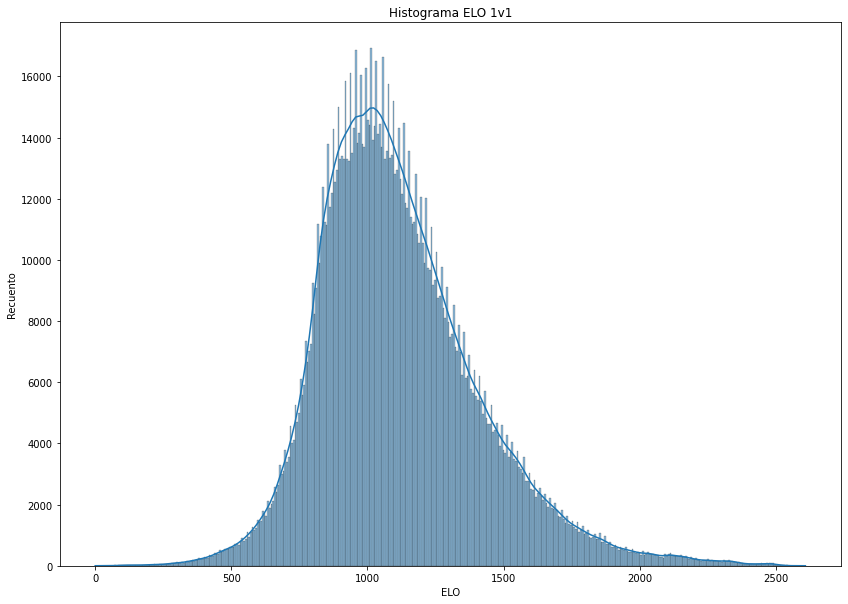

In [28]:
ax = sns.histplot(df_singleplayer.rating, stat="count", kde="True")
ax.set_title('Histograma ELO 1v1')
ax.set_ylabel('Recuento')
ax.set_xlabel('ELO')

<AxesSubplot:xlabel='rating'>

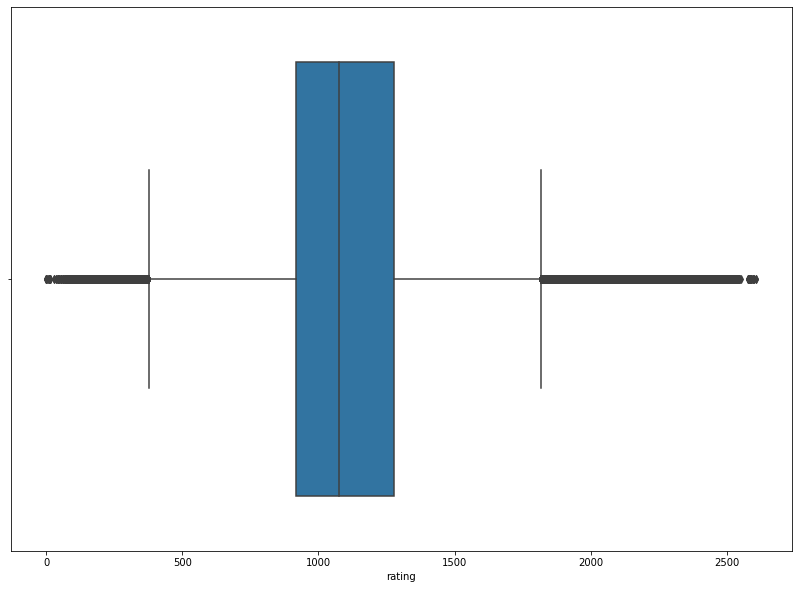

In [29]:
sns.boxplot(df_singleplayer.rating)

Text(0.5, 0, 'Duración en minutos')

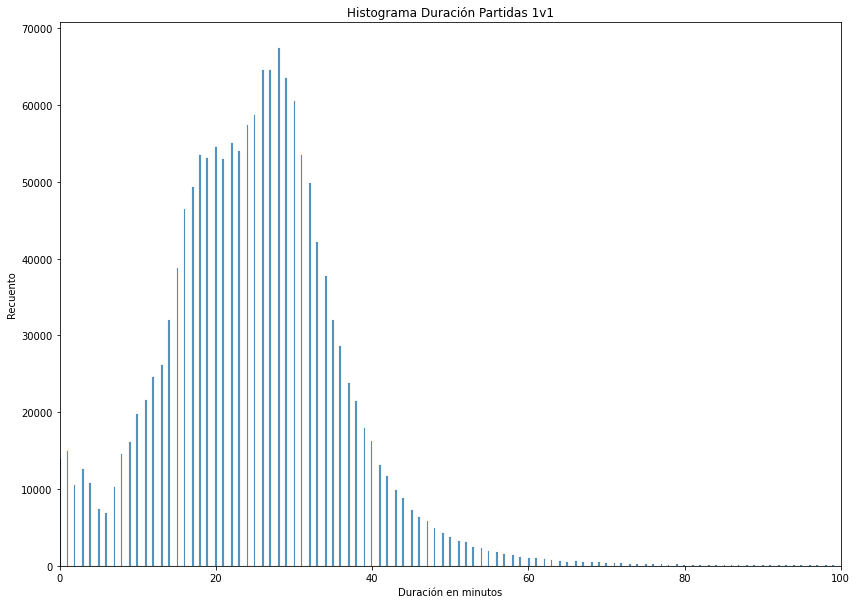

In [30]:
ax = sns.histplot(df_singleplayer.duration_minutes)
plt.xlim(0, 100)
ax.set_title('Histograma Duración Partidas 1v1')
ax.set_ylabel('Recuento')
ax.set_xlabel('Duración en minutos')

<AxesSubplot:xlabel='duration_minutes'>

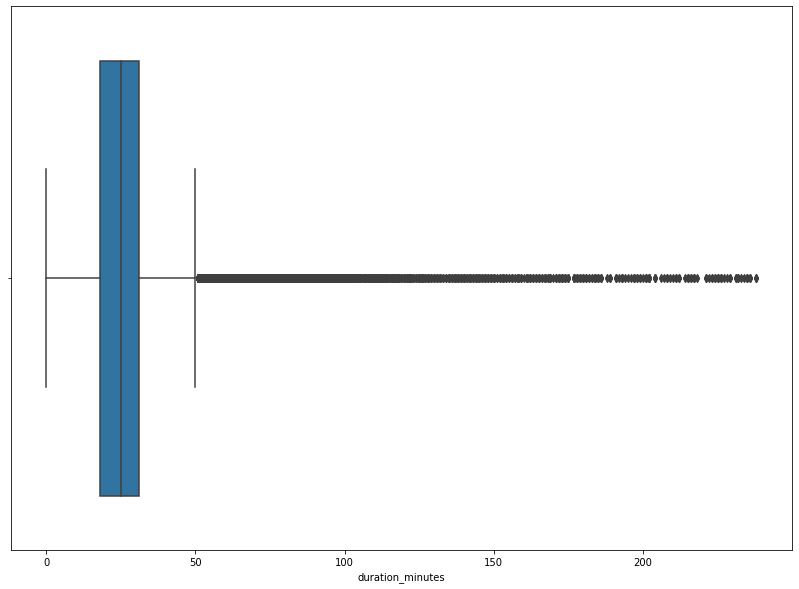

In [31]:
sns.boxplot(df_singleplayer.duration_minutes)

Text(0.5, 1.0, '% de Uso de Civilizaciones en partidas 1v1')

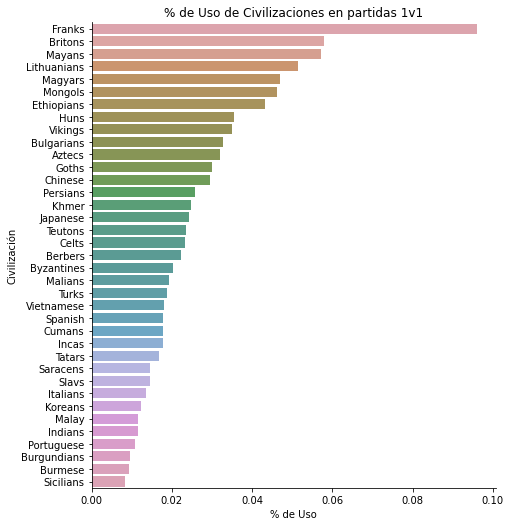

In [32]:
sns.catplot(y="civ", x="frequency",  data=frequency_civs_singleplayer, saturation=.5, kind="bar", ci=None, aspect=1, height=7)
plt.ylabel("Civilización")
plt.xlabel("% de Uso")
plt.title("% de Uso de Civilizaciones en partidas 1v1")

Text(0.5, 1.0, 'Porcentaje de Victorias de Civilizaciones en partidas 1v1')

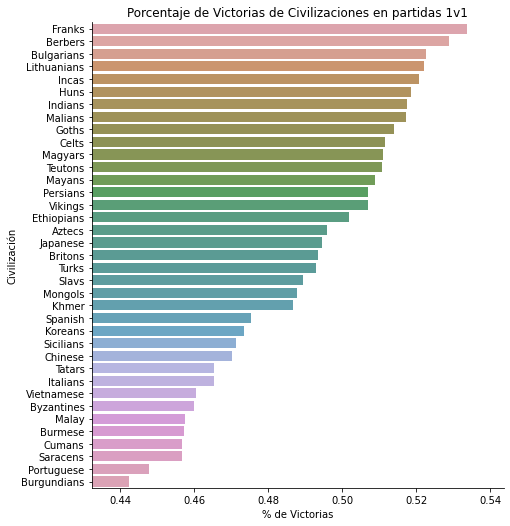

In [33]:
sns.catplot(y="civ", x="win_rate",  data=winrate_civs_singleplayer, saturation=.5, kind="bar", ci=None, aspect=1, height=7)
plt.ylabel("Civilización")
plt.xlabel("% de Victorias")
lim_sup = float(winrate_civs_singleplayer.win_rate.head(1) + 0.01)
lim_inf = float(winrate_civs_singleplayer.win_rate.tail(1) - 0.01)
plt.xlim(lim_inf, lim_sup)
plt.title("Porcentaje de Victorias de Civilizaciones en partidas 1v1")

Text(0.5, 1.0, '% de Partidas por Mapa en partidas 1v1')

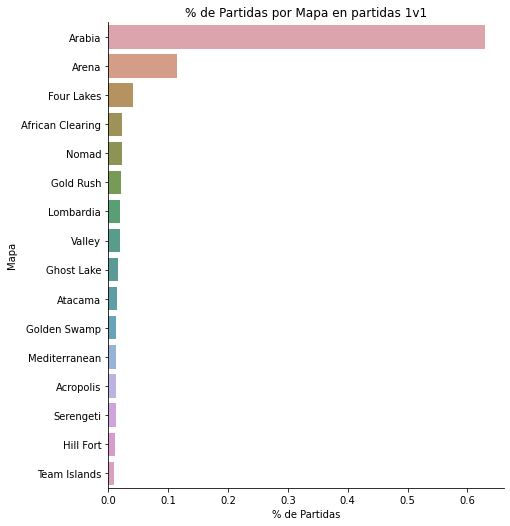

In [34]:
sns.catplot(y="map", x="frequency",  data=frequency_maps_singleplayer, saturation=.5, kind="bar", ci=None, aspect=1, height=7)
plt.ylabel("Mapa")
plt.xlabel("% de Partidas")
plt.title("% de Partidas por Mapa en partidas 1v1")

Text(0.5, 1.0, '% de Partidas por Color en partidas 1v1')

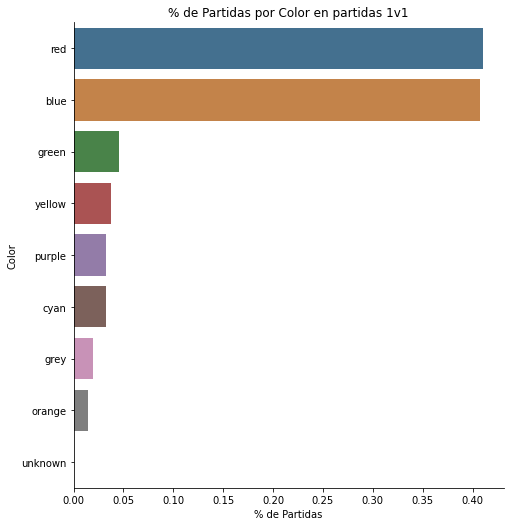

In [35]:
sns.catplot(y="color", x="frequency",  data=frequency_colors_singleplayer, saturation=.5, kind="bar", ci=None, aspect=1, height=7)
plt.ylabel("Color")
plt.xlabel("% de Partidas")
plt.title("% de Partidas por Color en partidas 1v1")

Text(0.5, 1.0, '% de Partidas por Servidor en partidas 1v1')

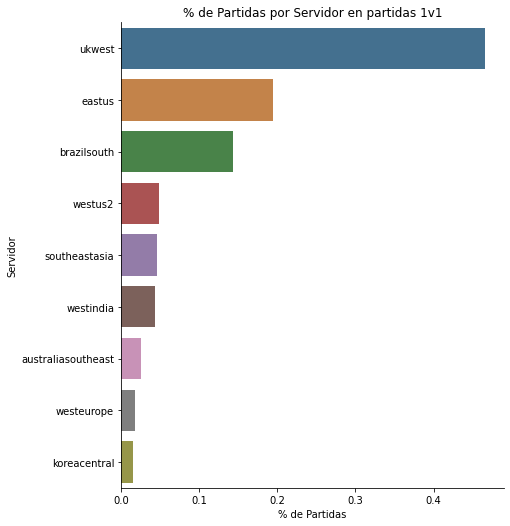

In [36]:
sns.catplot(y="server", x="frequency",  data=frequency_server_singleplayer, saturation=.5, kind="bar", ci=None, aspect=1, height=7)
plt.ylabel("Servidor")
plt.xlabel("% de Partidas")
plt.title("% de Partidas por Servidor en partidas 1v1")

Text(0.5, 1.0, '% de Partidas por Nacionalidad en partidas 1v1')

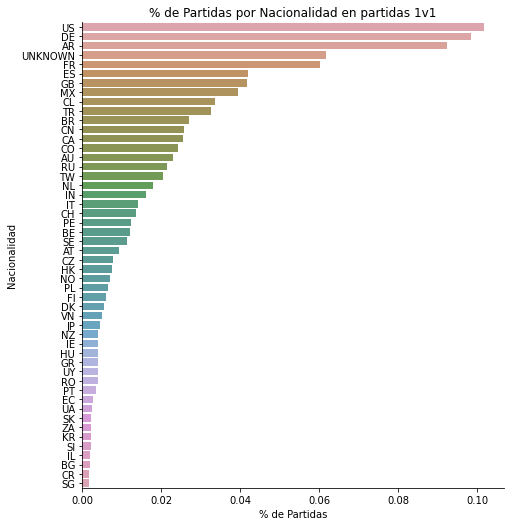

In [37]:
frequency_country_singleplayer = frequency_country_singleplayer.head(50)
sns.catplot(y="country", x="frequency",  data=frequency_country_singleplayer, saturation=.5, kind="bar", ci=None, aspect=1, height=7)
plt.ylabel("Nacionalidad")
plt.xlabel("% de Partidas")
plt.title("% de Partidas por Nacionalidad en partidas 1v1")

In [38]:
renames_singleplayer = {
    "profile_id": "opponent",
    "civ": "opponent_civ",
}
opponents_singleplayer = df_singleplayer[["match_id", "profile_id", "civ"]].rename(columns=renames_singleplayer)
vs_df_singleplayer = pd.merge(df_singleplayer, opponents_singleplayer, left_on="match_id", right_on="match_id").rename(columns={"profile_id": "player"})

# Dado que hemos fusionado el mismo marco de datos un jugador será un oponente de sí mismo, debemos eliminar esas filas.
vs_df_singleplayer = vs_df_singleplayer[vs_df_singleplayer["player"] != vs_df_singleplayer["opponent"]]
vs_df_singleplayer = vs_df_singleplayer[["match_id", "player", "opponent", "civ", "opponent_civ", "won"]]

In [39]:
vs_df_singleplayer.head(6)

,match_id,player,opponent,civ,opponent_civ,won
1,79168344,444319,4232849,Saracens,Burgundians,1
2,79168344,4232849,444319,Burgundians,Saracens,0
5,79168372,1614015,2475419,Aztecs,Magyars,1
6,79168372,2475419,1614015,Magyars,Aztecs,0
9,79168575,2619416,4380659,Huns,Persians,0
10,79168575,4380659,2619416,Persians,Huns,1


In [40]:
# Matriz cuadrada del porcentaje de victorias de civilizaciones vs el resto de civilizaciones.
win_vs_singleplayer = vs_df_singleplayer.pivot_table(values="won", index="civ", columns="opponent_civ")
win_vs_singleplayer.head(10)

opponent_civ,Aztecs,Berbers,Britons,Bulgarians,Burgundians,Burmese,Byzantines,Celts,Chinese,Cumans,...,Portuguese,Saracens,Sicilians,Slavs,Spanish,Tatars,Teutons,Turks,Vietnamese,Vikings
civ,,,,,,,,,,,,,,,,,,,,,
Aztecs,0.500000,0.500000,0.519567,0.422836,0.549801,0.505470,0.555444,0.479419,0.523711,0.555679,...,0.533552,0.542974,0.456954,0.468835,0.479215,0.549437,0.473769,0.482659,0.546265,0.456161
Berbers,0.500000,0.500000,0.544276,0.517463,0.585859,0.518272,0.521531,0.498079,0.577228,0.565062,...,0.587432,0.510638,0.574405,0.562130,0.565295,0.652529,0.528905,0.554924,0.604839,0.517442
Britons,0.480433,0.455724,0.500000,0.490710,0.556531,0.567532,0.563646,0.500000,0.548619,0.521549,...,0.573248,0.561699,0.494638,0.521203,0.519947,0.549648,0.522243,0.523566,0.513258,0.510660
Bulgarians,0.577164,0.482537,0.509290,0.500000,0.584158,0.610132,0.586172,0.575214,0.536388,0.599338,...,0.558577,0.529178,0.587379,0.548295,0.525967,0.525028,0.473822,0.546275,0.545738,0.516007
Burgundians,0.450199,0.414141,0.443469,0.415842,0.500000,0.445122,0.507599,0.432065,0.468468,0.510714,...,0.539773,0.405172,0.488000,0.470339,0.449275,0.488462,0.435754,0.420896,0.488722,0.409002
Burmese,0.494530,0.481728,0.432468,0.389868,0.554878,0.500000,0.578571,0.467606,0.455982,0.485294,...,0.530303,0.429167,0.523810,0.526549,0.461078,0.406639,0.452926,0.472843,0.420455,0.413276
Byzantines,0.444556,0.478469,0.436354,0.413828,0.492401,0.421429,0.500000,0.428752,0.490385,0.501608,...,0.520089,0.515222,0.391003,0.453763,0.494253,0.523305,0.467844,0.465574,0.488673,0.426445
Celts,0.520581,0.501921,0.500000,0.424786,0.567935,0.532394,0.571248,0.500000,0.549282,0.570513,...,0.533679,0.561508,0.531157,0.543893,0.505731,0.548658,0.492433,0.474510,0.537459,0.487520
Chinese,0.476289,0.422772,0.451381,0.463612,0.531532,0.544018,0.509615,0.450718,0.500000,0.489481,...,0.533632,0.528244,0.529255,0.475336,0.539523,0.500615,0.456803,0.472152,0.507732,0.471286


Text(0.5, 1.0, 'Porcentaje de Victorias de cada Civilización vs el resto de Civilizaciones')

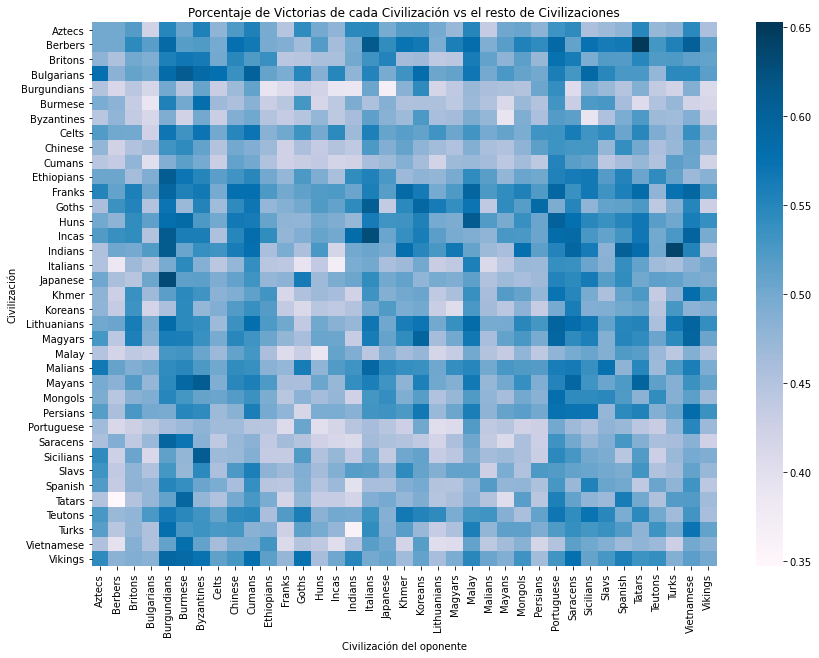

In [41]:
from pylab import rcParams
rcParams['figure.figsize'] = 14, 10
sns.heatmap(win_vs_singleplayer, cmap="PuBu")
plt.ylabel("Civilización")
plt.xlabel("Civilización del oponente")
plt.title("Porcentaje de Victorias de cada Civilización vs el resto de Civilizaciones")

In [42]:
melted_win_vs_singleplayer = win_vs_singleplayer.unstack().reset_index().rename(columns={0: "win_rate"})
melted_win_vs_singleplayer.sort_values("win_rate").nlargest(10, columns="win_rate").reset_index(drop=True)
melted_win_vs_singleplayer = melted_win_vs_singleplayer[["civ", "opponent_civ", "win_rate"]]
melted_win_vs_singleplayer.nlargest(10, columns="win_rate").reset_index(drop=True)

,civ,opponent_civ,win_rate
0,Berbers,Tatars,0.652529
1,Indians,Turks,0.638629
2,Japanese,Burgundians,0.630282
3,Incas,Italians,0.628169
4,Berbers,Italians,0.613426
5,Indians,Burgundians,0.612565
6,Incas,Burgundians,0.611111
7,Huns,Malay,0.610922
8,Bulgarians,Burmese,0.610132
9,Mayans,Byzantines,0.609464


In [43]:
win_maps_singleplayer = df_singleplayer.pivot_table(values="won", index="civ", columns="map_type")
win_maps_singleplayer.head(10)

map_type,Acropolis,African Clearing,Arabia,Arena,Atacama,Four Lakes,Ghost Lake,Gold Rush,Golden Swamp,Hill Fort,Lombardia,Mediterranean,Nomad,Serengeti,Team Islands,Valley
civ,,,,,,,,,,,,,,,,
Aztecs,0.460784,0.470167,0.490647,0.532468,0.490701,0.474430,0.491690,0.496683,0.485420,0.471366,0.492167,0.478161,0.479751,0.479323,0.488722,0.510152
Berbers,0.566972,0.525677,0.532422,0.404389,0.522917,0.545079,0.589416,0.564978,0.515829,0.561514,0.501330,0.542411,0.542828,0.555769,0.574468,0.509855
Britons,0.449490,0.418723,0.499693,0.497427,0.462810,0.472605,0.520666,0.480639,0.510825,0.471154,0.495040,0.447793,0.400374,0.471933,0.405759,0.468259
Bulgarians,0.552878,0.534378,0.521369,0.526428,0.514286,0.522104,0.520092,0.517682,0.573748,0.524409,0.533023,0.521845,0.500000,0.514116,0.460784,0.513790
Burgundians,0.456221,0.469974,0.420355,0.468556,0.449799,0.457711,0.477193,0.435696,0.461864,0.525000,0.492447,0.523973,0.422951,0.455556,0.425197,0.471947
Burmese,0.437500,0.448718,0.451947,0.489939,0.420792,0.456274,0.478049,0.416357,0.497326,0.460784,0.483019,0.459893,0.438871,0.372222,0.444444,0.459259
Byzantines,0.463470,0.462437,0.448716,0.475264,0.419725,0.480349,0.424116,0.450223,0.492366,0.470085,0.445604,0.491457,0.467143,0.437037,0.565217,0.456522
Celts,0.474328,0.496394,0.509697,0.530438,0.482505,0.549323,0.468085,0.500763,0.500000,0.528634,0.484956,0.505470,0.504528,0.477833,0.492823,0.490536
Chinese,0.475915,0.545052,0.469243,0.452553,0.483221,0.440410,0.484992,0.506297,0.457090,0.513021,0.476464,0.462651,0.450287,0.465209,0.420792,0.479137


Text(0.5, 1.0, 'Porcentaje de Victorias de cada Civilización por Mapa')

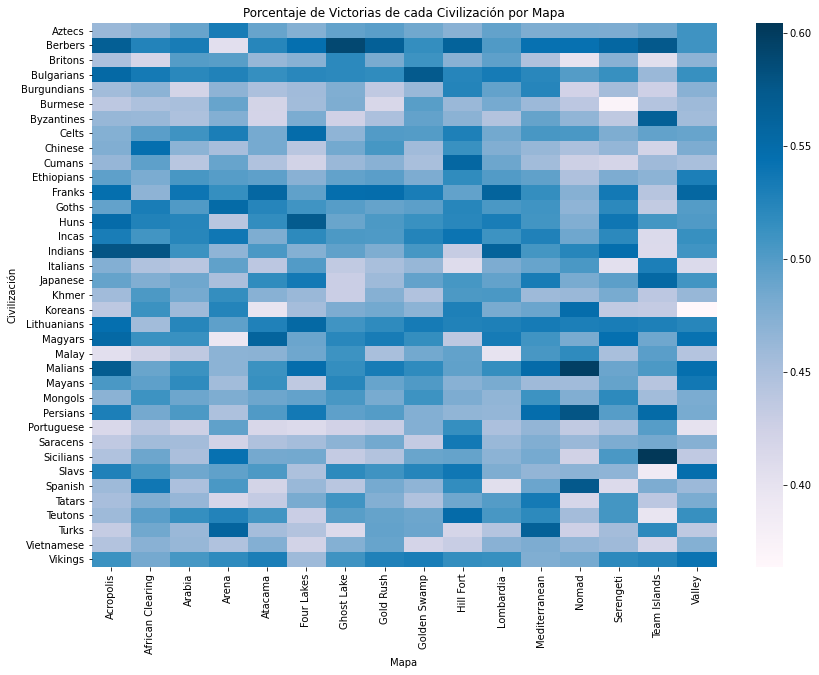

In [44]:
sns.heatmap(win_maps_singleplayer, cmap="PuBu")
plt.ylabel("Civilización")
plt.xlabel("Mapa")
plt.title("Porcentaje de Victorias de cada Civilización por Mapa")

In [45]:
melted_winmap_vs_singleplayer = win_maps_singleplayer.unstack().reset_index().rename(columns={0: "win_rate"})
melted_winmap_vs_singleplayer.sort_values("win_rate").nlargest(10, columns="win_rate").reset_index(drop=True)
melted_winmap_vs_singleplayer = melted_winmap_vs_singleplayer[["civ", "map_type", "win_rate"]]
melted_winmap_vs_singleplayer.nlargest(10, columns="win_rate").reset_index(drop=True)

,civ,map_type,win_rate
0,Sicilians,Team Islands,0.604348
1,Malians,Nomad,0.597605
2,Berbers,Ghost Lake,0.589416
3,Indians,African Clearing,0.578636
4,Indians,Acropolis,0.578431
5,Persians,Nomad,0.578065
6,Spanish,Nomad,0.575000
7,Berbers,Team Islands,0.574468
8,Bulgarians,Golden Swamp,0.573748
9,Huns,Four Lakes,0.572864


#### ANÁLISIS PARTIDAS MULTIPLAYER.

In [46]:
# Comprobación de valores NaN de cada variable.
df_multiplayer.isna().sum()

match_id                 0
version                  0
map_size                 0
map_type                 0
rating_type              0
server                   0
duration_minutes         0
profile_id               0
player_name             88
country                  0
rating              144865
color                    0
team                     0
civ                      0
won                      0
dtype: int64

In [47]:
df_multiplayer.describe()

,match_id,version,duration_minutes,profile_id,rating,team,won
count,2.500966e+06,2500966.0,2.500966e+06,2.500966e+06,2.356101e+06,2500966.0,2500966.0
mean,8.426880e+07,46295.0,3.195938e+01,2.649825e+06,1.690566e+03,1.5,0.5
std,2.758384e+06,0.0,1.712793e+01,1.649986e+06,4.951042e+02,0.5,0.5
min,7.916903e+07,46295.0,0.000000e+00,1.320000e+02,4.360000e+02,1.0,0.0
25%,8.188174e+07,46295.0,2.300000e+01,1.260398e+06,1.306000e+03,1.0,0.0
50%,8.440747e+07,46295.0,3.000000e+01,2.505002e+06,1.618000e+03,1.5,0.5
75%,8.662574e+07,46295.0,3.800000e+01,4.150631e+06,2.057000e+03,2.0,1.0
max,8.892602e+07,46295.0,2.400000e+02,5.681045e+06,3.331000e+03,2.0,1.0


Text(0.5, 0, 'ELO')

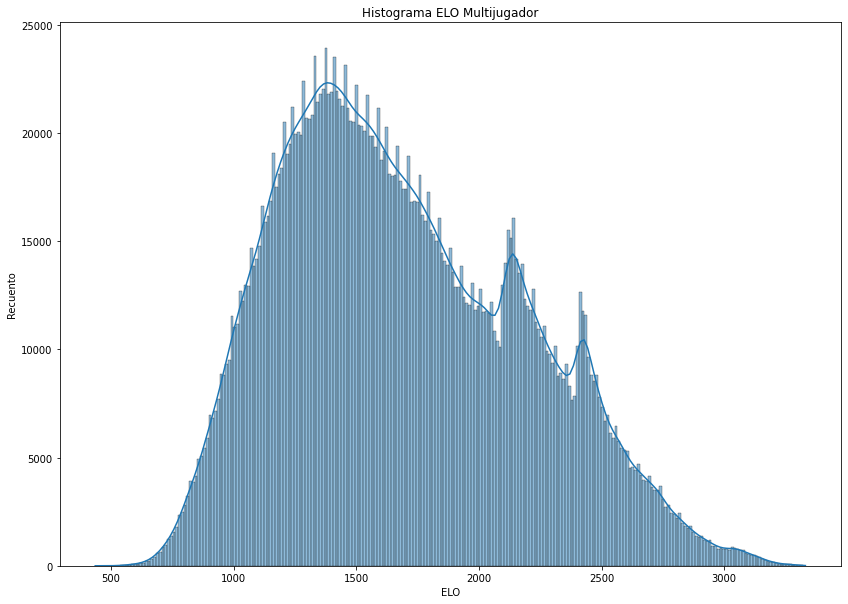

In [48]:
ax = sns.histplot(df_multiplayer.rating, stat="count", kde=True)
ax.set_title('Histograma ELO Multijugador')
ax.set_ylabel('Recuento')
ax.set_xlabel('ELO')

<AxesSubplot:xlabel='rating'>

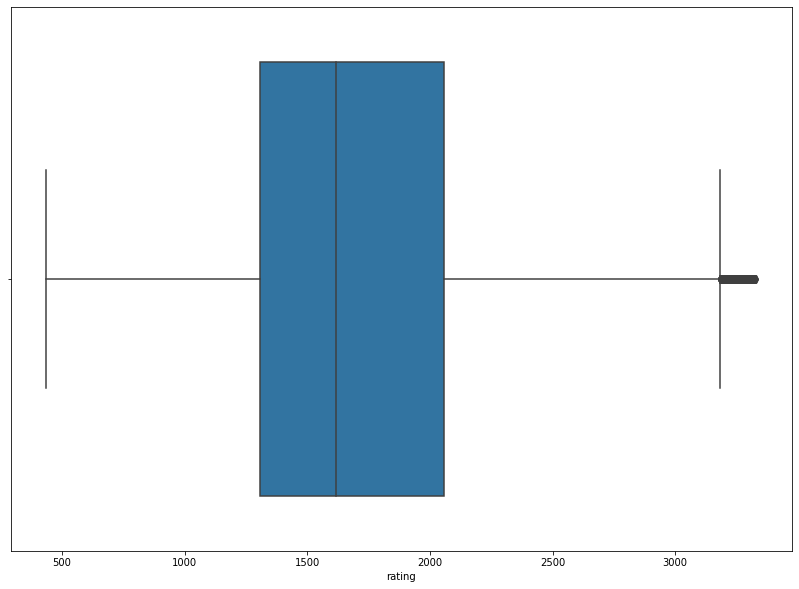

In [49]:
sns.boxplot(df_multiplayer.rating)

Text(0.5, 0, 'Duración en minutos')

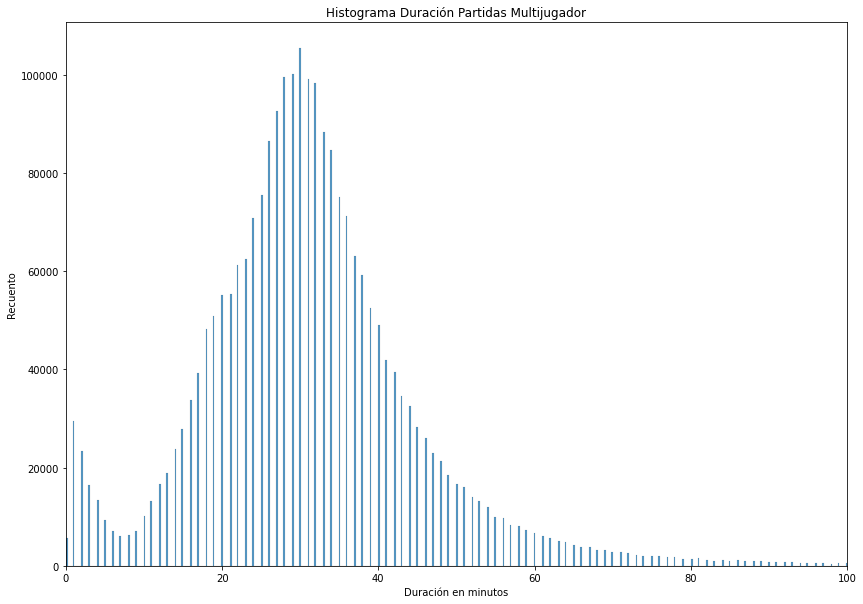

In [50]:
ax = sns.histplot(df_multiplayer.duration_minutes)
plt.xlim(0, 100)
ax.set_title('Histograma Duración Partidas Multijugador')
ax.set_ylabel('Recuento')
ax.set_xlabel('Duración en minutos')

(0.0, 100.0)

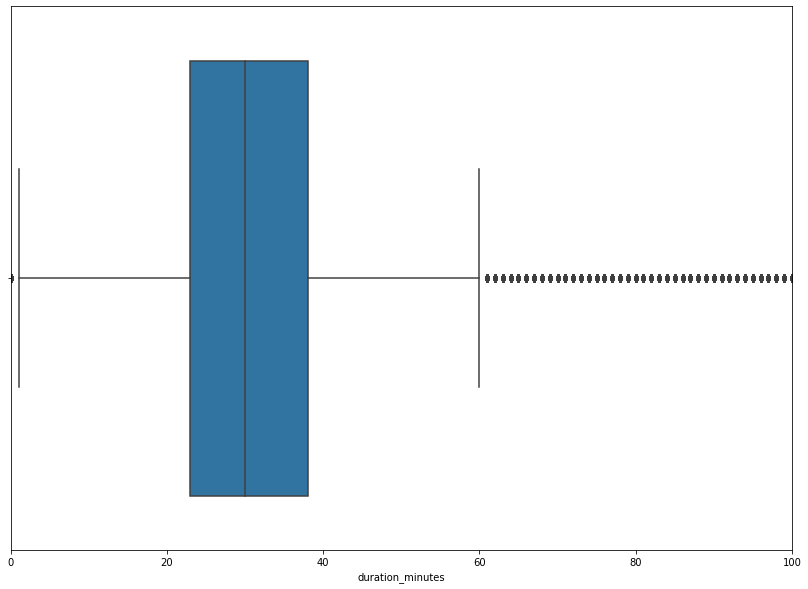

In [51]:
sns.boxplot(df_multiplayer.duration_minutes)
plt.xlim(0, 100)

Text(0.5, 1.0, '% de Uso de Civilizaciones en partidas multijugador')

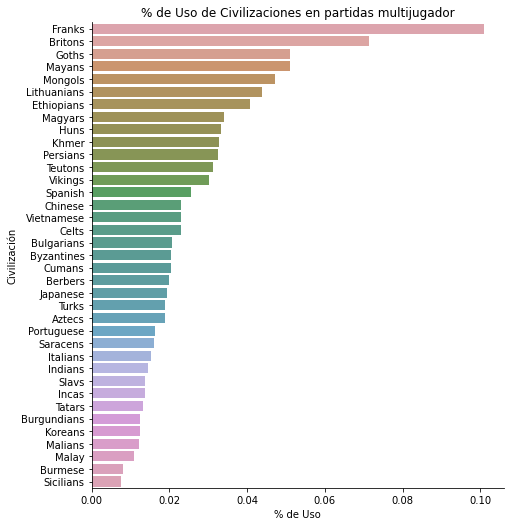

In [52]:
sns.catplot(y="civ", x="frequency",  data=frequency_civs_multiplayer, saturation=.5, kind="bar", ci=None, aspect=1, height=7)
plt.ylabel("Civilización")
plt.xlabel("% de Uso")
plt.title("% de Uso de Civilizaciones en partidas multijugador")

Text(0.5, 1.0, 'Porcentaje de Victorias de Civilizaciones en partidas multijugador')

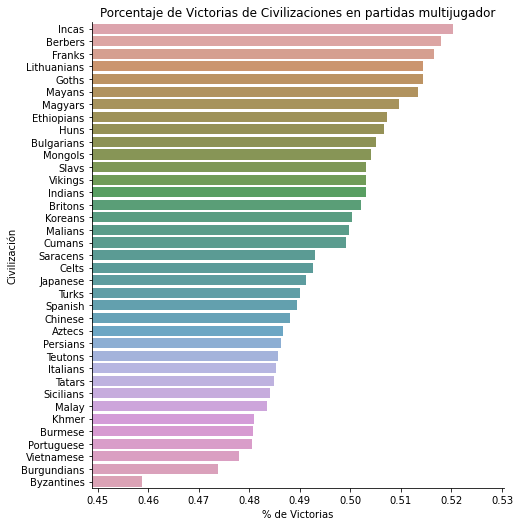

In [53]:
sns.catplot(y="civ", x="win_rate",  data=win_rate_civs_multiplayer, saturation=.5, kind="bar", ci=None, aspect=1, height=7)
plt.ylabel("Civilización")
plt.xlabel("% de Victorias")
lim_sup = float(win_rate_civs_multiplayer.win_rate.head(1) + 0.01)
lim_inf = float(win_rate_civs_multiplayer.win_rate.tail(1) - 0.01)
plt.xlim(lim_inf, lim_sup)
plt.title("Porcentaje de Victorias de Civilizaciones en partidas multijugador")

Text(0.5, 1.0, '% de Partidas por Mapa en partidas multijugador')

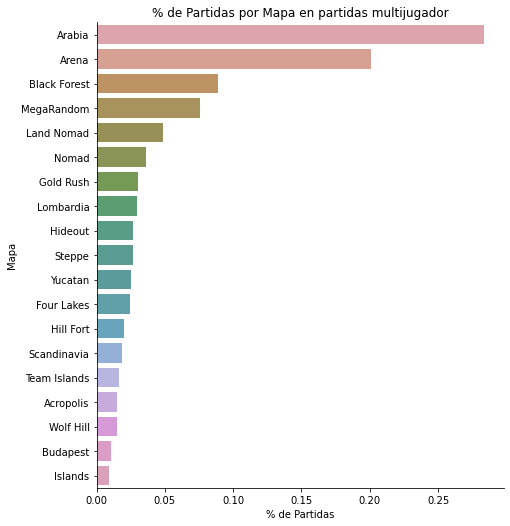

In [54]:
sns.catplot(y="map", x="frequency",  data=frequency_maps_multiplayer, saturation=.5, kind="bar", ci=None, aspect=1, height=7)
plt.ylabel("Mapa")
plt.xlabel("% de Partidas")
plt.title("% de Partidas por Mapa en partidas multijugador")

Text(0.5, 1.0, '% de Partidas por Color en partidas multijugador')

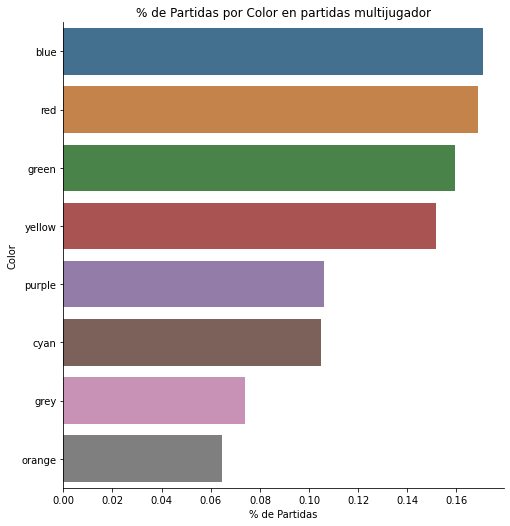

In [55]:
sns.catplot(y="color", x="frequency",  data=frequency_color_multiplayer, saturation=.5, kind="bar", ci=None, aspect=1, height=7)
plt.ylabel("Color")
plt.xlabel("% de Partidas")
plt.title("% de Partidas por Color en partidas multijugador")

Text(0.5, 1.0, '% de Partidas por Servidor en partidas multijugador')

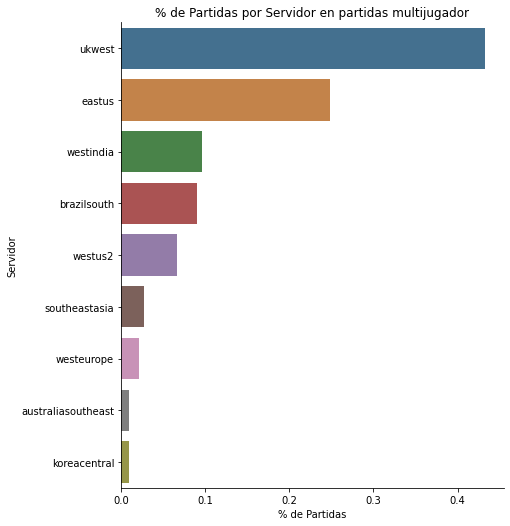

In [56]:
sns.catplot(y="server", x="frequency",  data=frequency_server_multiplayer, saturation=.5, kind="bar", ci=None, aspect=1, height=7)
plt.ylabel("Servidor")
plt.xlabel("% de Partidas")
plt.title("% de Partidas por Servidor en partidas multijugador")

Text(0.5, 1.0, '% de Partidas por Nacionalidad en partidas multijugador')

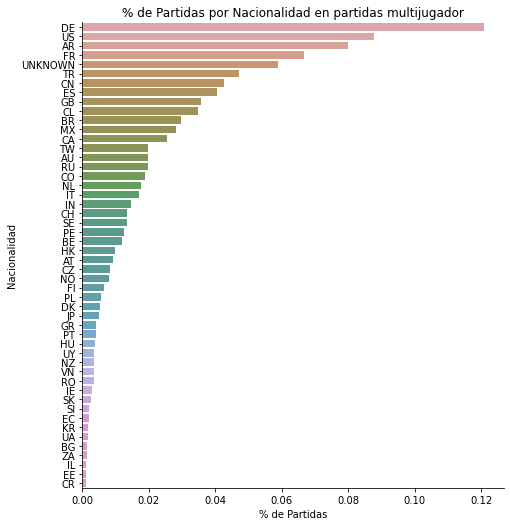

In [57]:
frequency_country_multiplayer = frequency_country_multiplayer.head(50)
sns.catplot(y="country", x="frequency",  data=frequency_country_multiplayer, saturation=.5, kind="bar", ci=None, aspect=1, height=7)
plt.ylabel("Nacionalidad")
plt.xlabel("% de Partidas")
plt.title("% de Partidas por Nacionalidad en partidas multijugador")

In [58]:
renames_multiplayer = {
    "profile_id": "opponent",
    "civ": "opponent_civ",
}
opponents_multiplayer = df_multiplayer[["match_id", "profile_id", "civ"]].rename(columns=renames_multiplayer)
vs_df_multiplayer = pd.merge(df_multiplayer, opponents_multiplayer, left_on="match_id", right_on="match_id").rename(columns={"profile_id": "player"})

# Dado que hemos fusionado el mismo marco de datos un jugador será un oponente de sí mismo, debemos eliminar esas filas.
vs_df_multiplayer = vs_df_multiplayer[vs_df_multiplayer["player"] != vs_df_multiplayer["opponent"]]
vs_df_multiplayer = vs_df_multiplayer[["match_id", "player", "opponent", "civ", "opponent_civ", "won"]]

In [59]:
# Matriz cuadrada del porcentaje de victorias de civilizaciones vs el resto de civilizaciones.
win_vs_multiplayer = vs_df_multiplayer.pivot_table(values="won", index="civ", columns="opponent_civ")
win_vs_multiplayer.head(10)

opponent_civ,Aztecs,Berbers,Britons,Bulgarians,Burgundians,Burmese,Byzantines,Celts,Chinese,Cumans,...,Portuguese,Saracens,Sicilians,Slavs,Spanish,Tatars,Teutons,Turks,Vietnamese,Vikings
civ,,,,,,,,,,,,,,,,,,,,,
Aztecs,0.492706,0.473420,0.490395,0.490617,0.505403,0.494459,0.496367,0.490556,0.502210,0.490923,...,0.485512,0.487583,0.494202,0.491270,0.487966,0.487323,0.478771,0.483627,0.485185,0.488932
Berbers,0.526797,0.500460,0.518807,0.522526,0.538251,0.517426,0.524224,0.527796,0.517037,0.508211,...,0.521617,0.520773,0.523947,0.500163,0.519719,0.528936,0.513301,0.527416,0.518388,0.525529
Britons,0.501470,0.510062,0.496089,0.503690,0.502823,0.500994,0.499631,0.506579,0.505245,0.497469,...,0.498014,0.510627,0.493134,0.508158,0.497733,0.502179,0.504869,0.503574,0.498595,0.506083
Bulgarians,0.519150,0.498383,0.494823,0.494021,0.505641,0.497580,0.515191,0.507313,0.505303,0.513332,...,0.504743,0.496566,0.511996,0.512079,0.501012,0.504415,0.512960,0.518895,0.504714,0.494380
Burgundians,0.506234,0.455504,0.478129,0.476247,0.501615,0.464512,0.481658,0.482308,0.469538,0.466393,...,0.498768,0.482038,0.444643,0.479630,0.477850,0.463367,0.488957,0.479314,0.476911,0.476146
Burmese,0.474425,0.464879,0.485395,0.476463,0.492621,0.490927,0.486919,0.498932,0.486949,0.491235,...,0.471798,0.449599,0.493003,0.485911,0.490960,0.473534,0.497878,0.480738,0.475423,0.470946
Byzantines,0.465435,0.465663,0.459191,0.451850,0.459815,0.466570,0.487885,0.454162,0.447883,0.466019,...,0.485714,0.468995,0.466420,0.461786,0.463215,0.453729,0.469788,0.467759,0.457231,0.480270
Celts,0.492535,0.495276,0.490864,0.487757,0.513655,0.504630,0.501015,0.500781,0.493113,0.504794,...,0.499450,0.494555,0.508249,0.489249,0.505695,0.478964,0.498903,0.490226,0.505371,0.483465
Chinese,0.491160,0.492647,0.488792,0.483113,0.487154,0.502700,0.485972,0.491228,0.487337,0.495951,...,0.490852,0.500236,0.492857,0.496906,0.498302,0.493489,0.495271,0.499628,0.495915,0.487673


Text(0.5, 1.0, 'Porcentajde de Victorias de cada Civilización vs el resto de Civilizaciones')

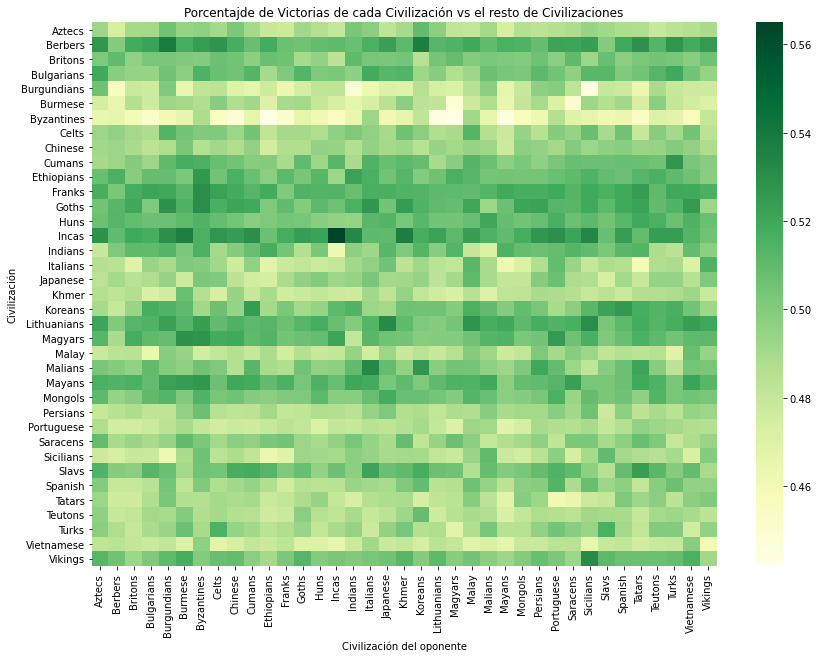

In [60]:
sns.heatmap(win_vs_multiplayer,  cmap="YlGn")
plt.ylabel("Civilización")
plt.xlabel("Civilización del oponente")
plt.title("Porcentajde de Victorias de cada Civilización vs el resto de Civilizaciones")

In [61]:
melted_win_vs_multiplayer = win_vs_multiplayer.unstack().reset_index().rename(columns={0: "win_rate"})
melted_win_vs_multiplayer.sort_values("win_rate").nlargest(10, columns="win_rate").reset_index(drop=True)
melted_win_vs_multiplayer = melted_win_vs_multiplayer[["civ", "opponent_civ", "win_rate"]]
melted_win_vs_multiplayer.nlargest(10, columns="win_rate").reset_index(drop=True)

,civ,opponent_civ,win_rate
0,Incas,Incas,0.565013
1,Berbers,Burgundians,0.538251
2,Berbers,Koreans,0.537318
3,Incas,Khmer,0.537152
4,Incas,Burmese,0.537073
5,Incas,Sicilians,0.533055
6,Incas,Indians,0.532714
7,Malians,Italians,0.532534
8,Lithuanians,Japanese,0.531548
9,Vikings,Sicilians,0.531366


In [62]:
win_maps_multiplayer = df_multiplayer.pivot_table(values="won", index="civ", columns="map_type")
win_maps_multiplayer.head(10)

map_type,Acropolis,Arabia,Arena,Black Forest,Budapest,Four Lakes,Gold Rush,Hideout,Hill Fort,Islands,Land Nomad,Lombardia,MegaRandom,Nomad,Scandinavia,Steppe,Team Islands,Wolf Hill,Yucatan
civ,,,,,,,,,,,,,,,,,,,
Aztecs,0.506569,0.470712,0.495711,0.477166,0.430255,0.483159,0.460610,0.468577,0.503289,0.447917,0.505819,0.507291,0.495403,0.491512,0.490934,0.470163,0.526829,0.522462,0.485326
Berbers,0.546858,0.519436,0.473894,0.451318,0.503667,0.546773,0.544433,0.507029,0.557742,0.496528,0.528250,0.532946,0.521036,0.549093,0.524590,0.527842,0.531915,0.527174,0.513233
Britons,0.502445,0.513804,0.491375,0.494743,0.523030,0.490935,0.516500,0.511900,0.486775,0.400424,0.483758,0.496066,0.501965,0.469896,0.494770,0.511773,0.479268,0.507711,0.500881
Bulgarians,0.509969,0.492630,0.530417,0.490368,0.515008,0.536542,0.491727,0.526973,0.475645,0.460000,0.505646,0.506141,0.500496,0.486551,0.501053,0.498940,0.571429,0.494792,0.504369
Burgundians,0.479612,0.468246,0.477639,0.472576,0.488798,0.476987,0.450980,0.453875,0.500826,0.466102,0.498885,0.472165,0.473293,0.479793,0.447791,0.429670,0.440329,0.532951,0.481888
Burmese,0.479401,0.445624,0.510462,0.482782,0.412791,0.509383,0.466527,0.496785,0.475480,0.400000,0.479204,0.452030,0.454816,0.524376,0.491857,0.463366,0.419048,0.442748,0.459641
Byzantines,0.444000,0.433765,0.466863,0.466531,0.478032,0.466719,0.465297,0.448437,0.453763,0.540969,0.455090,0.420391,0.456343,0.459177,0.473573,0.464451,0.504878,0.447452,0.461600
Celts,0.461078,0.474489,0.513456,0.508703,0.509294,0.469711,0.444840,0.481481,0.480916,0.440476,0.495078,0.483509,0.470073,0.488020,0.475597,0.482759,0.446108,0.428805,0.463396
Chinese,0.490996,0.487347,0.490223,0.479364,0.465875,0.461826,0.487821,0.454352,0.486898,0.405128,0.514192,0.469075,0.500109,0.477088,0.492553,0.538805,0.437690,0.471154,0.493101


Text(0.5, 1.0, 'Porcentajde de Victorias de cada Civilización por Mapa')

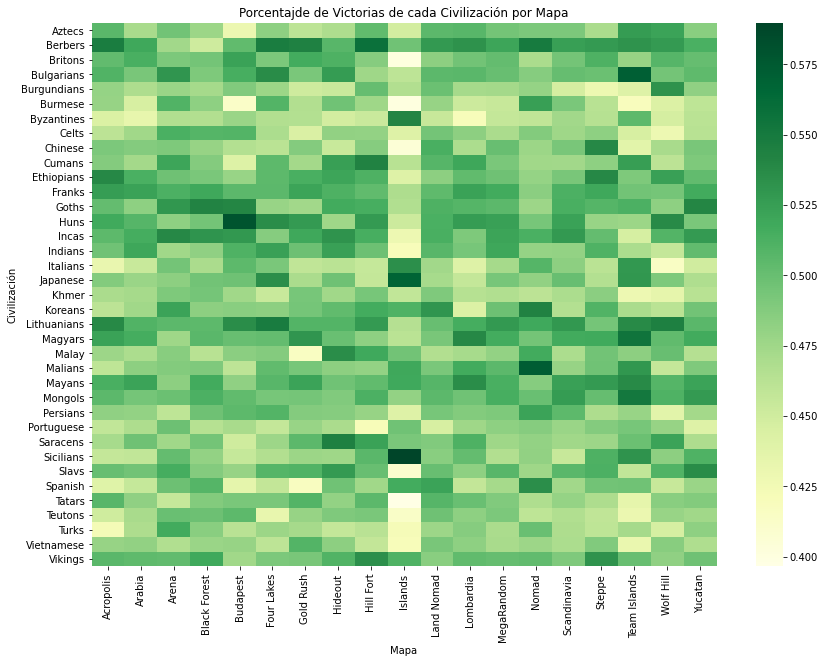

In [63]:
sns.heatmap(win_maps_multiplayer,  cmap="YlGn")
plt.ylabel("Civilización")
plt.xlabel("Mapa")
plt.title("Porcentajde de Victorias de cada Civilización por Mapa")

In [64]:
melted_winmap_vs_multiplayer = win_maps_multiplayer.unstack().reset_index().rename(columns={0: "win_rate"})
melted_winmap_vs_multiplayer.sort_values("win_rate").nlargest(10, columns="win_rate").reset_index(drop=True)
melted_winmap_vs_multiplayer = melted_winmap_vs_multiplayer[["civ", "map_type", "win_rate"]]
melted_winmap_vs_multiplayer.nlargest(10, columns="win_rate").reset_index(drop=True)

,civ,map_type,win_rate
0,Sicilians,Islands,0.589744
1,Huns,Budapest,0.578947
2,Malians,Nomad,0.573093
3,Bulgarians,Team Islands,0.571429
4,Japanese,Islands,0.568332
5,Berbers,Hill Fort,0.557742
6,Magyars,Team Islands,0.554286
7,Mongols,Team Islands,0.551948
8,Berbers,Nomad,0.549093
9,Lithuanians,Four Lakes,0.548157
